### Emely Seheon z5634253


Import statements

In [402]:
import numpy as np   # For general purpose array processing
import pandas as pd   # For working with data sets
from sklearn.model_selection import train_test_split   # Used to split data into train, test, and validation sets
from sklearn.preprocessing import StandardScaler   # Scales data for preprocessing
import keras   # For implementing neural networks
from tensorflow.keras.models import Sequential   # For building models layer by layer
from tensorflow.keras.layers import Dense   # For building a layer
import matplotlib.pyplot as plt   # For plotting
from sklearn.metrics import confusion_matrix, precision_score, balanced_accuracy_score   # To measure classification performance
from tensorflow.keras.optimizers import Adam   # Optimization algorithim
from tensorflow.keras.regularizers import l2   # To prevent overfitting
from sklearn.metrics import mean_absolute_error   # To measure loss in regression
from scipy.stats import pearsonr   # To calculate pearson correlation coefficient
from tensorflow.keras.models import load_model   # To load a saved model

#### Classification Task

- Include a random seed to ensure the results are reproducible
- Load the dataset using Pandas
- Peek at the data

In [403]:
# Random Seed
np.random.seed(42)

# Load the dataset
data = pd.read_csv('Climate_SPI.csv')

# Check the head of the data
print(data.head())

   year  month       u10       v10        mx2t        mn2t       tcc  \
0  1979      1 -2.958586 -0.634959  309.023720  297.283986  0.291988   
1  1979     10 -0.049360 -0.113635  302.851483  289.459347  0.192154   
2  1979     11 -0.404197 -0.341808  308.174168  294.707882  0.306703   
3  1979     12 -1.089172 -0.600055  310.344489  296.948569  0.327175   
4  1979      2 -2.160727 -0.715109  303.806692  294.093896  0.502479   

           t2            msl           t         q         u         v  \
0  302.992399  100796.767708  299.970613  0.008493 -4.568461 -2.839551   
1  296.133314  101346.796371  293.335081  0.004813 -2.372457 -3.721755   
2  301.354577  101135.556510  298.360025  0.005545 -2.794565 -3.715220   
3  303.544371  100999.285534  300.545961  0.006324 -3.429895 -3.687178   
4  298.759323  101125.883929  297.114917  0.009923 -3.892438 -2.943332   

            z       SPI  grid_ID  
0  459.991748 -0.715037      303  
1  904.832294 -0.246504      303  
2  751.517519 -0.

##### Data Preprocessing

- Create a Drought column
    - In a classification problem, the target variable needs to be binary
- Split the data into features (x) and labels (y)
- Split into train, validation, and test sets
    - Training (70%)
    - Validation (15%) for tuning the model during training, to prevent overfitting and ensuring the model generalizes well to unseen data
    - test (15%)

In [404]:
# Create the Drought cloumn based on the SPI column
data['Drought'] = data['SPI'].apply(lambda x: 1 if x <= -1 else 0)

# Drop unecessary columns to create for features
x = data.drop(columns=['SPI', 'Drought', 'grid_ID', 'year'])

# Labels
cy = data['Drought']

# Train, validation, and test sets
x_train, x_temp, cy_train, cy_temp = train_test_split(x, cy, test_size = 0.3, random_state = 42)
x_val, x_test, cy_val, cy_test = train_test_split(x_temp, cy_temp, test_size = 0.5, random_state = 42)

- Normalize the features using StandardScaler, which shifts and scales data so that the relationships between features are preserved.
    - This is because neural networks perform better when the input data is on a similar scale. This helps improve convergence during training by preventing some features from dominating others due to their scale.

In [405]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

- To use 'month' as a feature, it needs to be encoded using cyclic encoding to ensure the model understands the relationship between December and January.

In [406]:
# Normalize the 'month' feature to the range [0, 2π]
data['month_normalized'] = 2 * np.pi * (data['month'] - 1) / 12

# Create the new 'cos' and 'sin' columns
data['month_cos'] = np.cos(data['month_normalized'])
data['month_sin'] = np.sin(data['month_normalized'])

# Drop the original 'month' and 'month_normalized' columns
data = data.drop(columns=['month', 'month_normalized'])

##### Build the neural network
- I used a feedforward neural network for binary classification
- The network should have fewer parameters that the number of samples divided by 10. 15121 samples/10 = 1512 parameters

- Input layer:
    - 32 neurons with ReLu activation
    - the input shape is defined as the number of features from the dataset (14)
- Hidden layer:
    - 16 neurons with ReLu activation
        - ReLu is commonly used because it helps solve the vanishing gradient problem and speeds up convergence
            - The vanishing gradient problem occurs when gradients, which are used for updating weights duuring backpropagation, become very small as they are propagated back through the layers of the network. This leads to a slow or stop in training
            - Relu keeps the gradient consistent for positive values, and outputs zero for negative inputs, which prevents this problem
            - Relu requires less computational efforts compared to sigmoid or tanh because it is a piecewise linear function. 
        - Relu(x) = max(0, x)
- Output layer:
    - 1 neuron with sigmoid activation
        - sigmoid sqaushes the output between 0 and 1, making it suitable for binary classification

- I used Adam for the optimizer because it is comonly used. It is known to be fast efficient, can handle sparse gradients (infrequent dataset features), and it performs well with minimal hyperparameter tuning
- Learning rate was determined through trial and error.
- Binary cross entropy is commonly used for classification problems because it looks at the differences between the probable distribution and the predicted values.

- Early stopping allows the model to continue training through epochs until the model's performance starts to degrade, which is a sign of overfitting.
    - Patience of 5: more patience leads to longer compute time

- 150 epochs:
    - I chose this number after trial and error. After settling on an architecture that worked, I noticed that the early stopping would typically stop training after around 100 epochs. 

- Batch size of 32:
    - Powers of 2 are preferred because of efficient memory utilization
    - Smaller batch sizes give faster convergence but introduce noise, while larger batch sizes have smoother gradients but slower convergence.
    - Convergence is when the training and validation error stops decreasing.

In [407]:
# Build the model
classification_model = Sequential([
    Dense(32, activation = 'relu', input_shape=(x_train.shape[1],)), # Input layer
    Dense(16, activation = 'relu'), # Hidden layer
    Dense(1, activation = 'sigmoid') # Output layer
])

# Compile the model
classification_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0005), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Implement early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

# Train the model
cHistory = classification_model.fit(x_train, cy_train, epochs = 150, batch_size = 32, validation_data = (x_val, cy_val), callbacks=[early_stopping_cb])

Epoch 1/150


C:\Users\emely\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7633 - loss: 0.5119 - val_accuracy: 0.8527 - val_loss: 0.3631
Epoch 2/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8549 - loss: 0.3712 - val_accuracy: 0.8545 - val_loss: 0.3383
Epoch 3/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8484 - loss: 0.3532 - val_accuracy: 0.8589 - val_loss: 0.3271
Epoch 4/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8541 - loss: 0.3456 - val_accuracy: 0.8536 - val_loss: 0.3232
Epoch 5/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.8552 - loss: 0.3454 - val_accuracy: 0.8611 - val_loss: 0.3189
Epoch 6/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8650 - loss: 0.3236 - val_accuracy: 0.8646 - val_loss: 0.3156
Epoch 7/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.8647 - loss: 0.3284 - val_accuracy: 0.8668 - val_loss: 0.3188
Epoch 8/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8642 - loss: 0.3265 - val_accuracy: 0.

#####Evaluate the model

Accuracy vs. epochs plot for training and validation sets

Observations:
- An exponential growth in the graph shows that the model is converging
- The validation accuracy fluctuates more than the training accuracy
- The training and validation lines are generally close together, indicating that there is little to no overfitting
- The graph is moderately unstable, this could be caused by a high learning rate or too complex of a model.

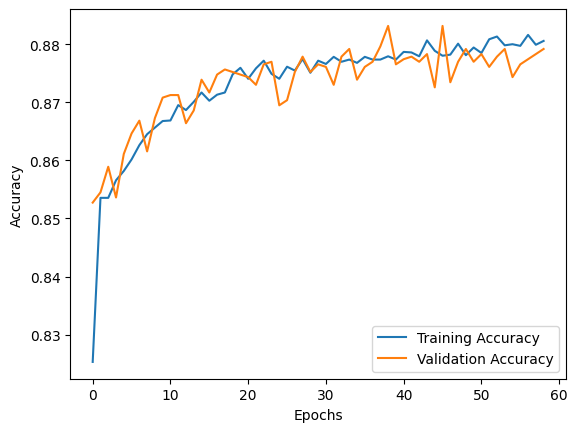

In [408]:
plt.plot(cHistory.history['accuracy'], label = 'Training Accuracy')   # Training accuracy
plt.plot(cHistory.history['val_accuracy'], label = 'Validation Accuracy')   # Validation accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- Confusion matrix
- Precision 
- Balanced accuracy

In [409]:
cy_pred = classification_model.predict(x_test) > 0.5 # Convert predictions to binary

print(confusion_matrix(cy_test, cy_pred))
print("Precision: ", precision_score(cy_test, cy_pred))
print("Balanced Accuracy: ", balanced_accuracy_score(cy_test, cy_pred))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[1895   76]
 [ 184  113]]
Precision:  0.5978835978835979
Balanced Accuracy:  0.6709561367095613


Save the classification model

In [410]:
classification_model.save('classification_model.keras')

#### Regression Task

##### Data Preprocessing

- Split the data into features (x) and labels (y)
- Split into train, validation, and test sets

In [411]:
# Labels
ry = data['SPI']

# Train, validation, and test sets
x_train, x_temp, ry_train, ry_temp = train_test_split(x, ry, test_size = 0.3, random_state = 42)
x_val, x_test, ry_val, ry_test = train_test_split(x_temp, ry_temp, test_size = 0.5, random_state = 42)

##### Build the neural network

- I used mostly the same architecture as the classification problem, snce the architecture is based on the dataset and not the problem.
- I used a linear activation function on the output because it does not transform the output, so the actual predicted output is returned.
 - MSE as a loss function is standard because it penalizes large errors
 - The learning rate ad batch size were aquired through trial and error

In [412]:
# Build the model
regression_model = Sequential([
    Dense(16, activation = 'relu', input_shape=(x_train.shape[1],)), # Input layer
    Dense(8, activation = 'relu'), # Hidden layer
    Dense(1, activation = 'linear') # Output layer
])

# Compile the model
regression_model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
# Train the model
rHistory = regression_model.fit(x_train, ry_train, epochs = 150, batch_size = 32, validation_data = (x_val, ry_val), callbacks=[early_stopping_cb])

Epoch 1/150


C:\Users\emely\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1725064192.0000 - val_loss: 1548434432.0000
Epoch 2/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1494700544.0000 - val_loss: 1339719680.0000
Epoch 3/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1291847936.0000 - val_loss: 1154415232.0000
Epoch 4/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1112114304.0000 - val_loss: 989584128.0000
Epoch 5/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 951860352.0000 - val_loss: 842888256.0000
Epoch 6/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 811068224.0000 - val_loss: 737505280.0000
Epoch 7/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 717514752.0000 - val_loss: 659193664.0000
Epoch 8/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 640898368.0000 - val_loss: 587356032.0000
Epoch 9/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 570525888.0000 - val_loss: 521148672.0000
Epoch 10/150
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 505591616.0000

##### Evaluate the model

Training and validation loss vs. epochs

Observations:
- An exponential decay in the graph shows that the model is converging
- The training and validation lines are close together, indicating that there is no overfitting

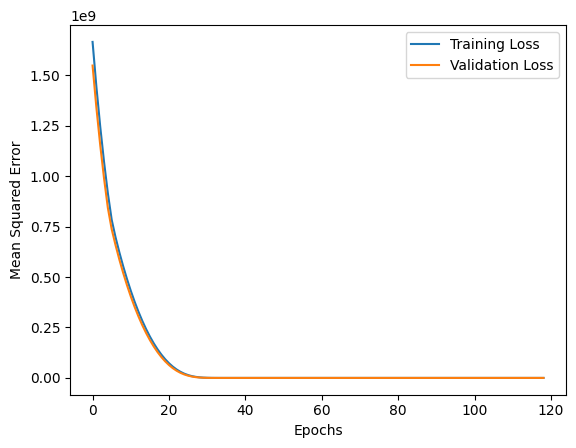

In [413]:
plt.plot(rHistory.history['loss'], label='Training Loss')
plt.plot(rHistory.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

##### Evaluate model performance on test set

In [414]:
test_loss = regression_model.evaluate(x_test, ry_test)
print("Test Loss (MSE): ", test_loss)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 3.5818
Test Loss (MSE):  3.674161911010742


Scatter plot to compare true vs. predicted values

Observations:
- The graph is roughly diaganol, meaning that there is some correlation between the true and predicted values.
- Since the points are not tighly clustered around the diagonal, there is a spread of errors. This could be solved by feature engineering or more hyperparameter tuning.
- Since the spread of points is wider at extreme values of SPI, the model seems to be struggling with predicting outlier values. This could be becuase of a lack of complexity in the model.

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


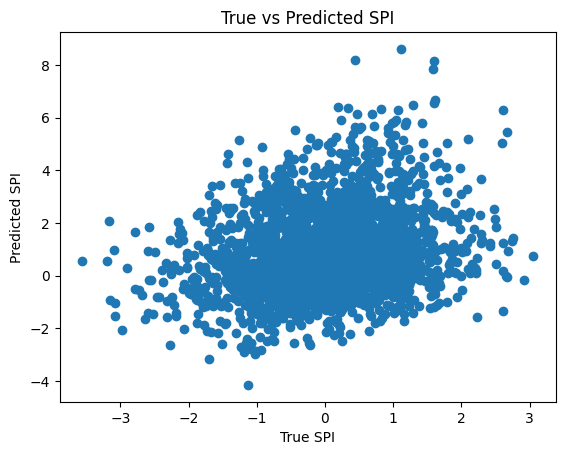

In [415]:
# Predict SPI values on the test set
ry_pred = regression_model.predict(x_test)

# Create a scatter plot
plt.scatter(ry_test, ry_pred)
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.title('True vs Predicted SPI')
plt.show()

- Mean absolute error
- Pearson correlation coefficient

In [416]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(ry_test, ry_pred)
print("Mean Absolute Error (MAE): ", mae)

# Pearson Correlation Coefficient
corr, _ = pearsonr(ry_test, ry_pred.flatten())  # Flatten the y_pred array
print("Pearson Correlation Coefficient: ", corr)

Mean Absolute Error (MAE):  1.4701237262299272
Pearson Correlation Coefficient:  0.23390795950987428


Save the regression model

In [417]:
regression_model.save('regression_model.keras')

#### Test classification model on a new dataset

In [418]:
# Process data
newData = pd.read_csv('Fake_Climate_SPI6.csv')
newData['Drought'] = newData['SPI'].apply(lambda x: 1 if x <= -1 else 0)

newX = newData.drop(columns = ['SPI', 'Drought', 'grid_ID', 'year'])
newXScaled = scaler.transform(newX)

# Load the model
loaded_class_model = load_model('classification_model.keras')
predCY = (loaded_class_model.predict(newXScaled) > 0.5)
trueCY = newData['Drought']

# Print results
print(confusion_matrix(trueCY, predCY))
print("Precision: ", precision_score(trueCY, predCY))
print("Balanced Accuracy: ", balanced_accuracy_score(trueCY, predCY))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[1642   74]
 [ 192  108]]
Precision:  0.5934065934065934
Balanced Accuracy:  0.6584382284382284


#### Test regression model on a new dataset

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


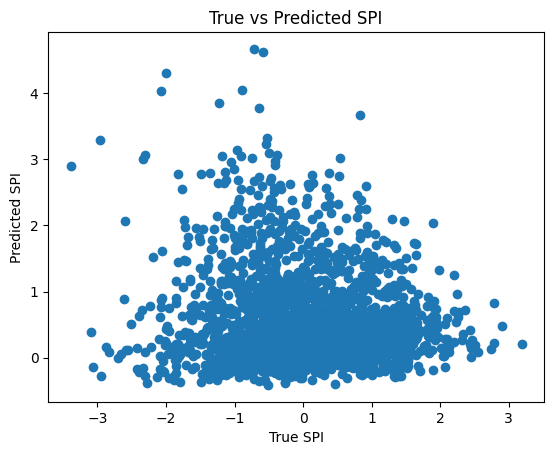

Mean Absolute Error (MAE):  1.064315523519036
Pearson Correlation Coefficient:  -0.10652098806286482


In [419]:
# Process data
newData = pd.read_csv('Fake_Climate_SPI6.csv')
newX = newData.drop(columns = ['SPI', 'grid_ID', 'year'])
newXScaled = scaler.transform(newX)

# Load the model
loaded_reg_model = load_model('regression_model.keras')
predRY = loaded_reg_model.predict(newXScaled)
trueRY = newData['SPI']

# Print results
# Scatter Plot
plt.scatter(trueRY, predRY)
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.title('True vs Predicted SPI')
plt.show()

# Mean Absolute Error (MAE)
mae = mean_absolute_error(trueRY, predRY)
print("Mean Absolute Error (MAE): ", mae)

# Pearson Correlation Coefficient
corr, _ = pearsonr(trueRY, predRY.flatten())  # Flatten the y_pred array
print("Pearson Correlation Coefficient: ", corr)